In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,Lasso
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from joblib import dump, load
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
###Training Set###

#Read the complete DataSet
df_train=pd.read_csv('Data/2C_Training.csv')
print('Training Data Set:\n',df_train.head()) #Applied Volts,Coulombs and Amps for all IGBTs
train_time=df_train['time']

#Separate out training Features as a dataframe: 09V-44V,Coulombs
df_xtrain = df_train.loc[:,'09V':'Coulombs']
print('df_xtrain:\n',df_xtrain.head())

#Separate out targets from the training set App_Amps for all IGBTs
df_ytrain = df_train.loc[:,'09A':'44A']
print('df_ytrain:\n',df_ytrain.head())

### Validation Data Set ###

#Read in the complete test dataset
df_test=pd.read_csv('Data/2C_Validation.csv')
test_time=df_test['time']
print('Validation Data Set:\n',df_test.head())

#Separate out features as a dataframe 09V-44V,Coulombs
df_xtest=df_test.loc[:,'09V':'Coulombs']
print('df_xtest:\n',df_xtest.head())

#separate out the targets from validation dataset App_Amps
df_ytest = df_test.loc[:,'09A':'44A']
print('df_ytest:\n',df_ytest.head())

Training Data Set:
    time  01V  02V  03V  04V  05V  06V  07V  08V  09V  ...  35A  36A  37A  38A  \
0     0    0    0    0    0    0    0    0    0   86  ...    0    0    0    0   
1     2    0    0    0    0    0    0    0    0  176  ...    0    0    0    0   
2     4    0    0    0    0    0    0    0    0  240  ...    0    0    0    0   
3     6    0    0    0    0    0    0    0    0  240  ...    0    0    0    0   
4     8    0    0    0    0    0    0    0    0  240  ...    0    0    0    0   

   39A  40A  41A  42A  43A  44A  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 91 columns]
df_xtrain:
    09V  10V  11V  12V  13V  14V  15V  16V  17V  18V  ...  36V  37V  38V  39V  \
0   86   86   86   86    0    0    0    0    0    0  ...    0    0    0    0   
1  176  176  176  176    0    0    0    0    0    0  ...    0    0    0    0   
2  240  240  2

Training Inputs (samples , features): (476, 37)
Training Outputs (samples , Targets): (476, 36)
Test Inputs (samples , features): (159, 37)
Test Outputs (samples , Targets): (159, 36)


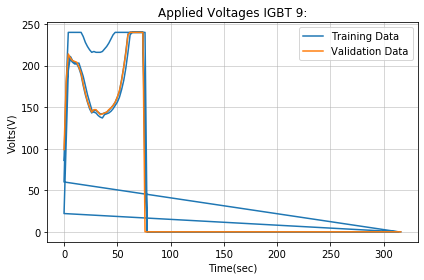

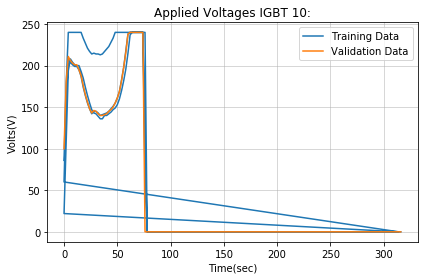

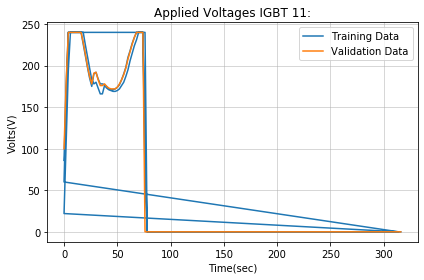

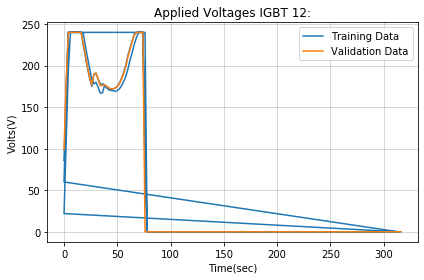

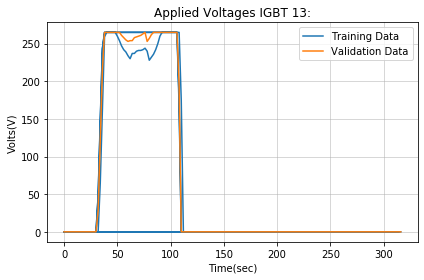

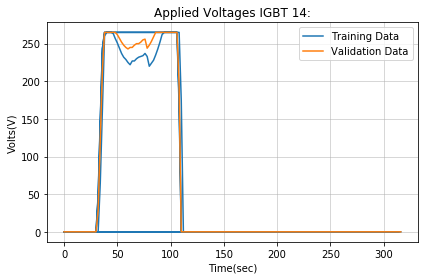

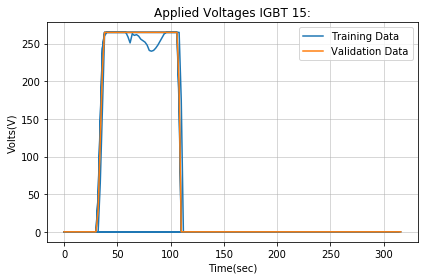

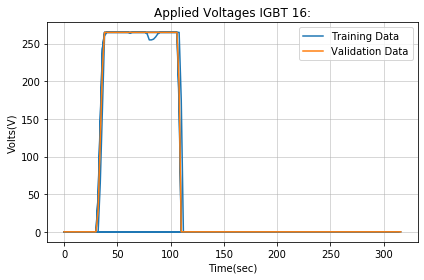

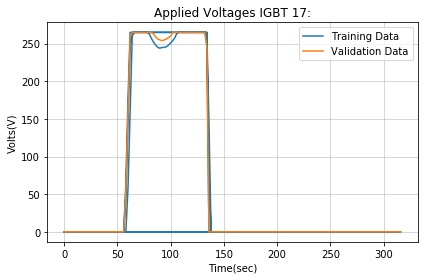

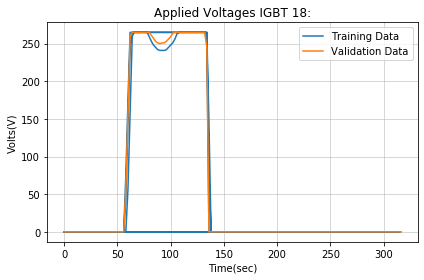

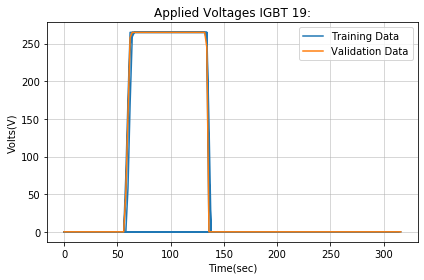

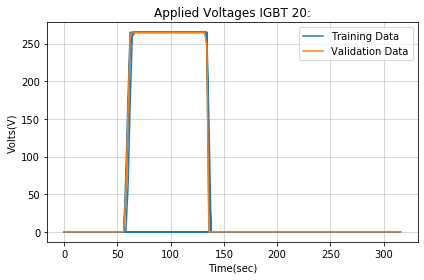

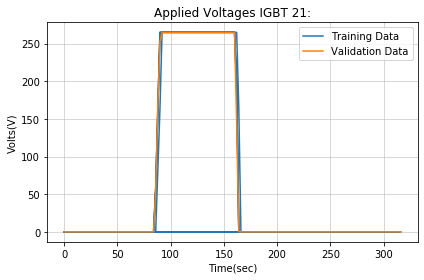

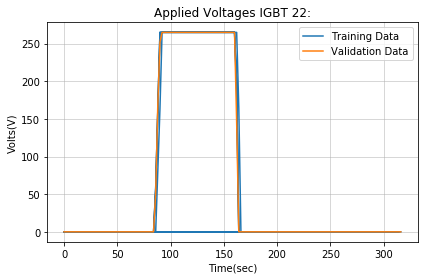

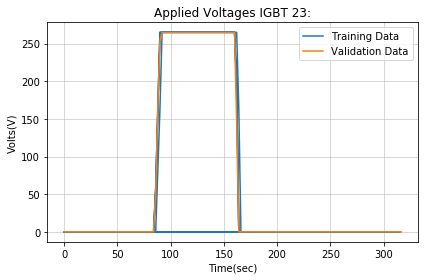

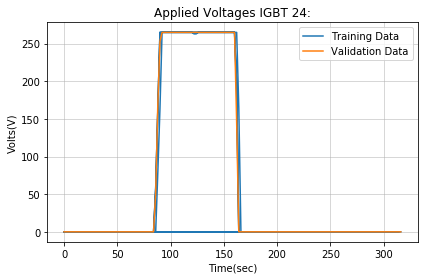

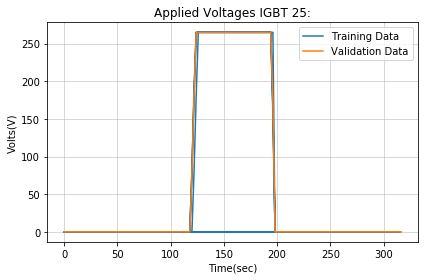

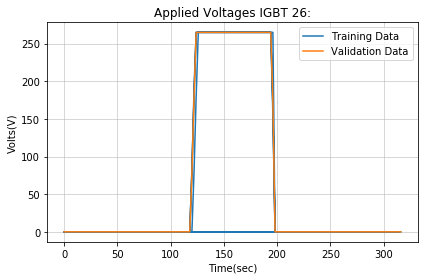

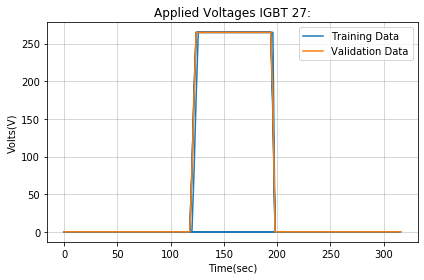

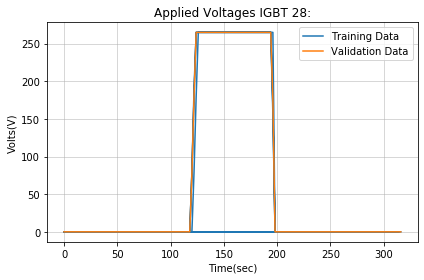

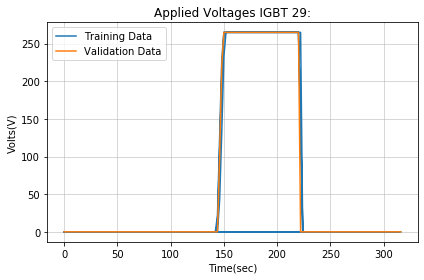

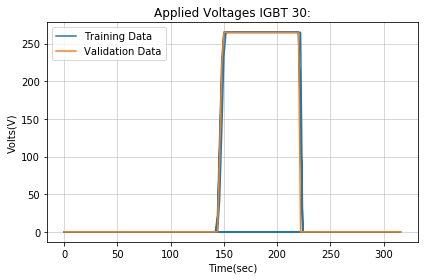

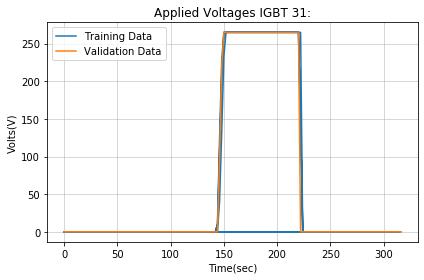

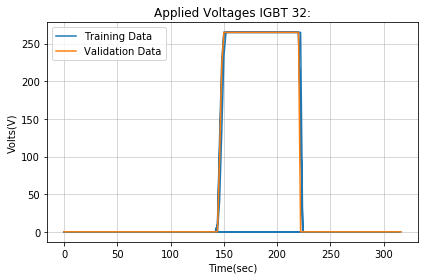

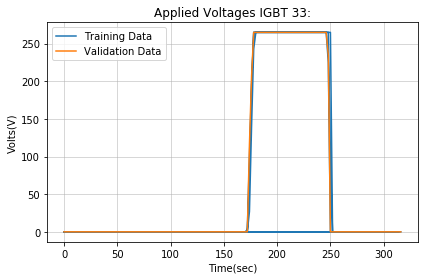

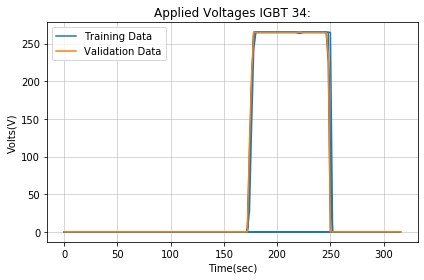

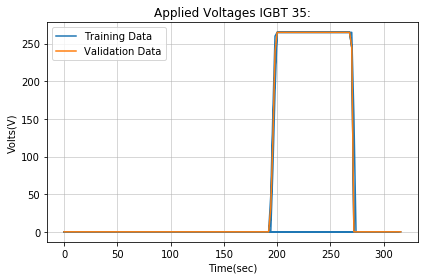

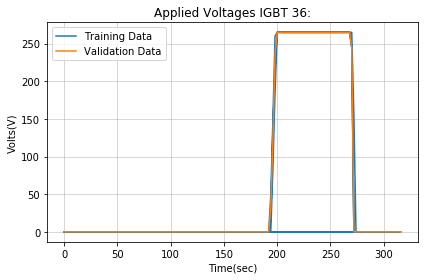

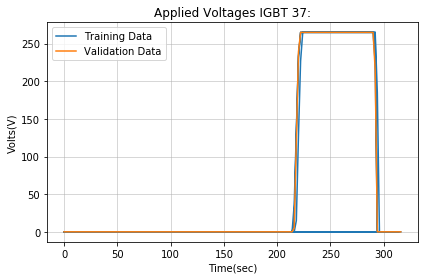

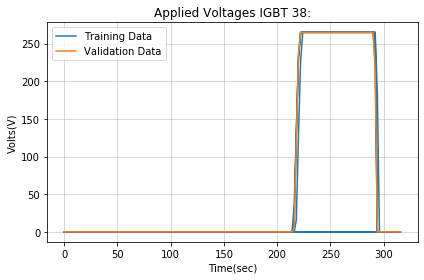

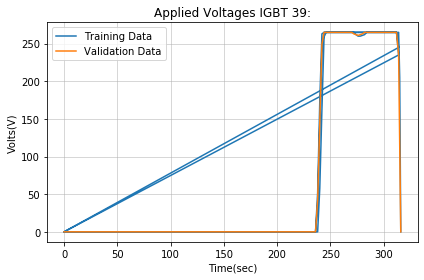

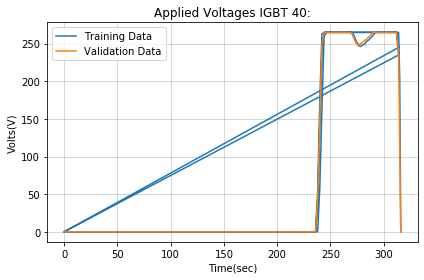

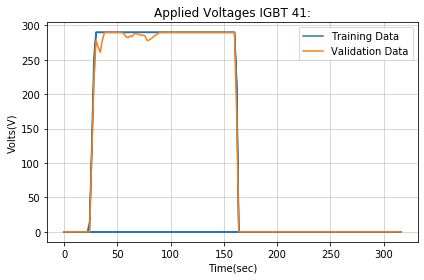

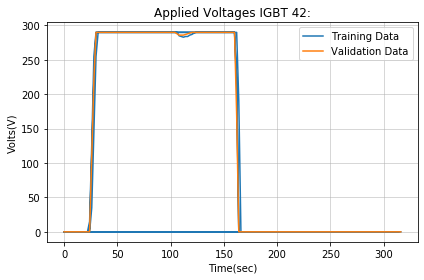

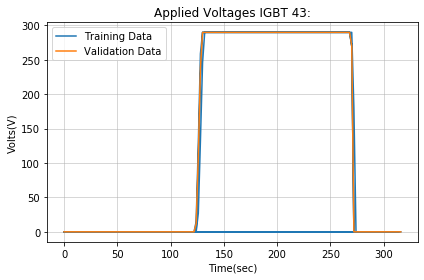

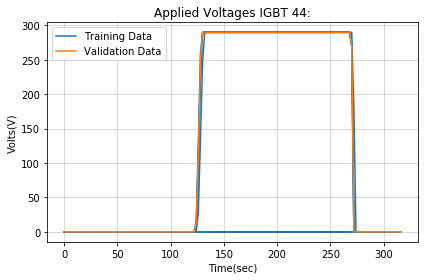

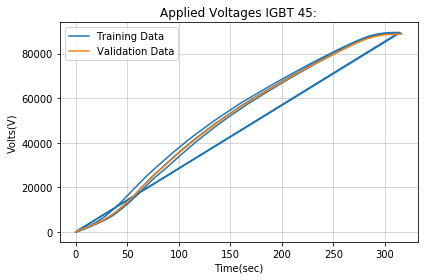

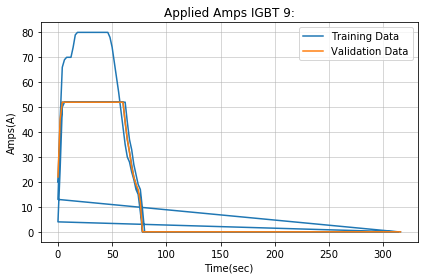

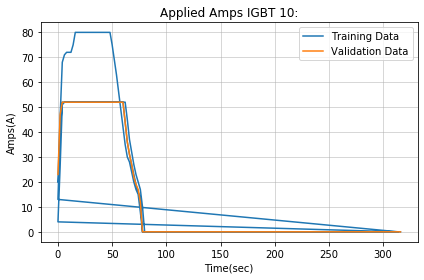

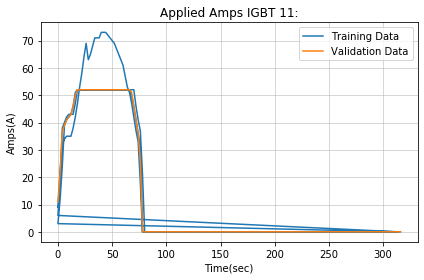

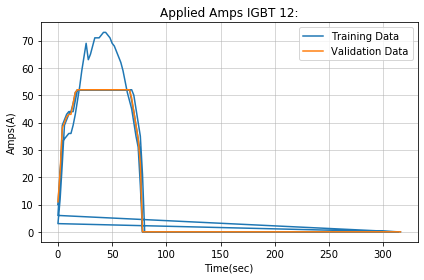

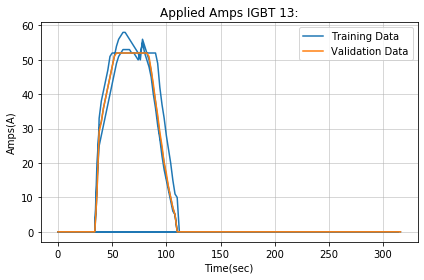

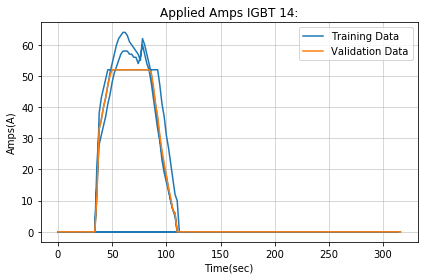

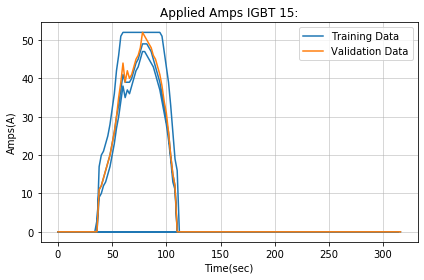

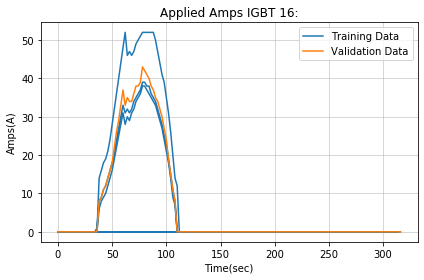

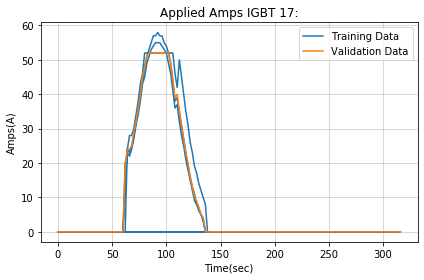

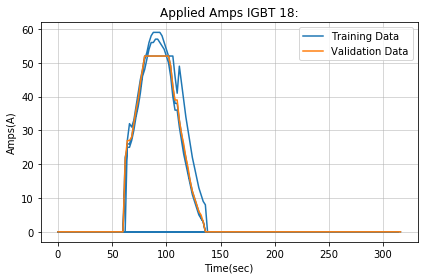

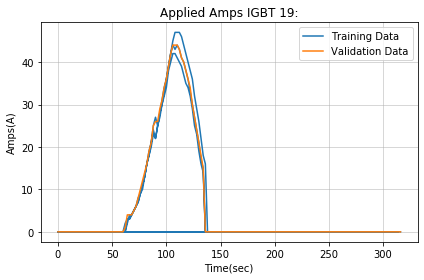

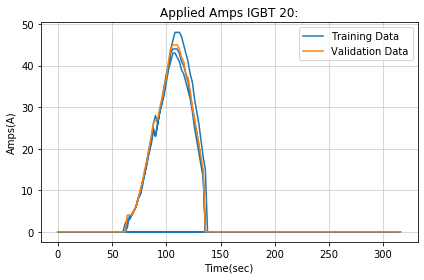

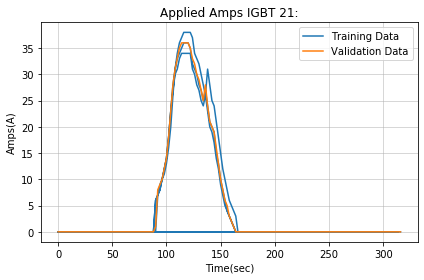

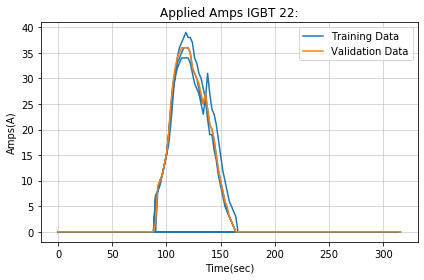

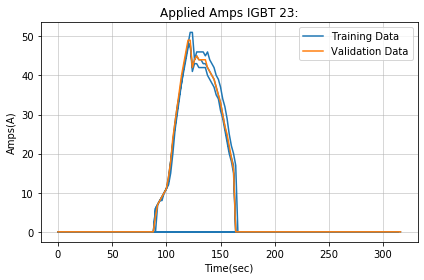

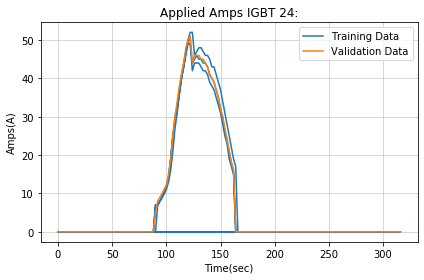

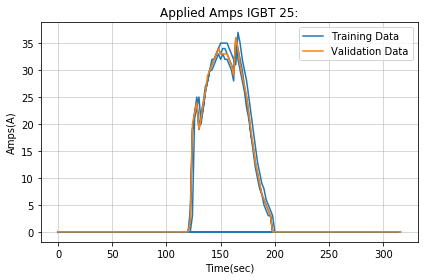

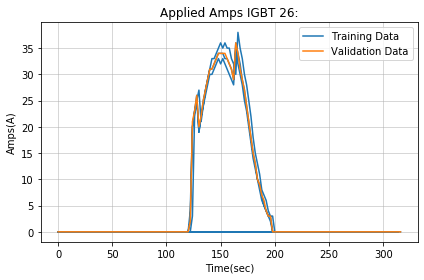

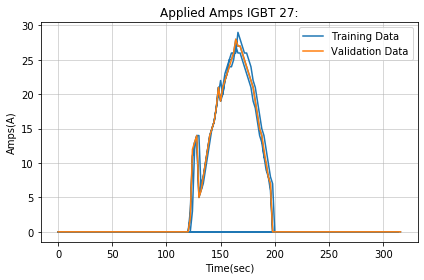

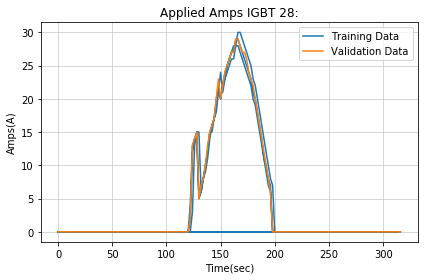

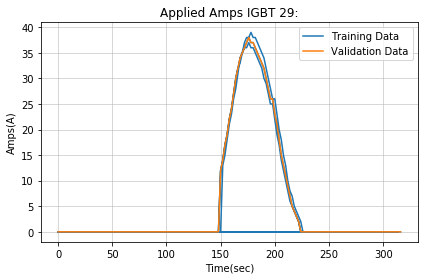

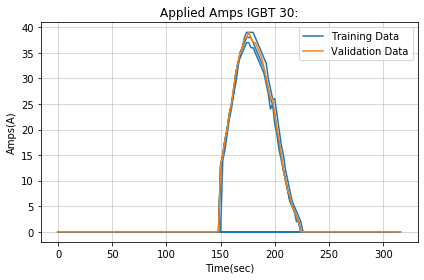

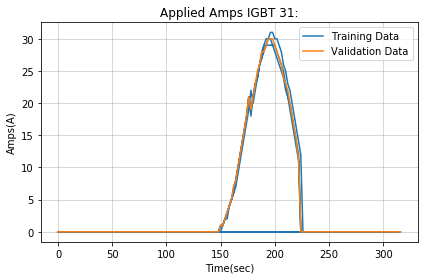

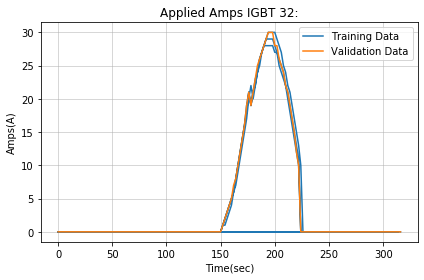

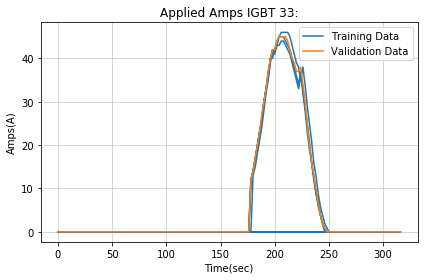

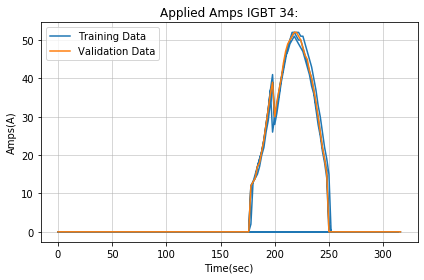

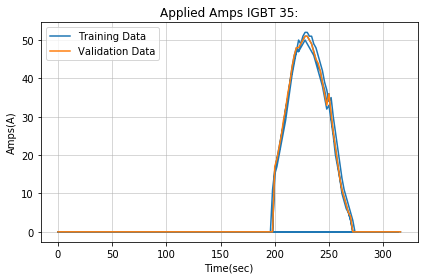

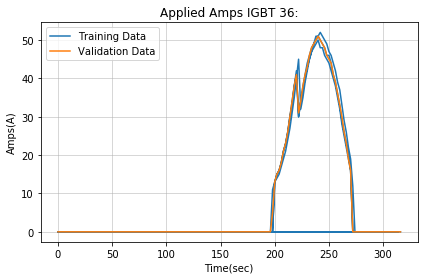

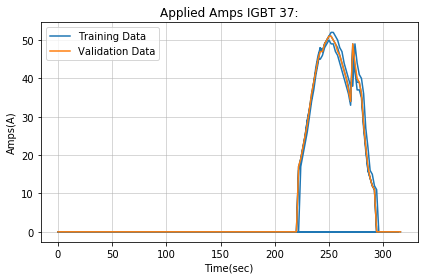

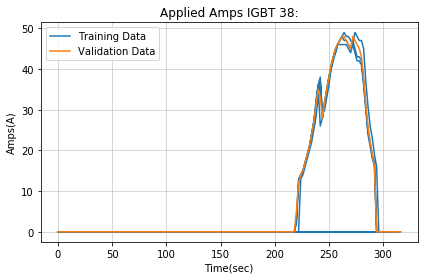

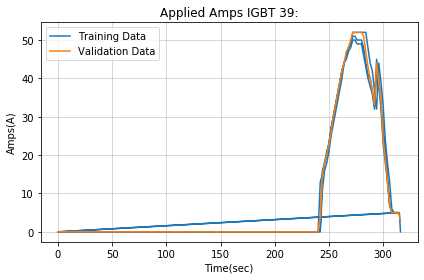

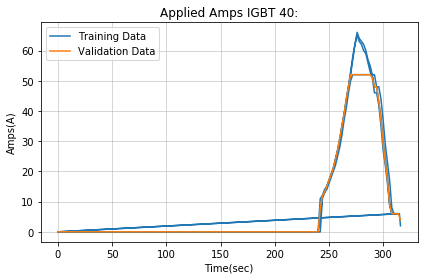

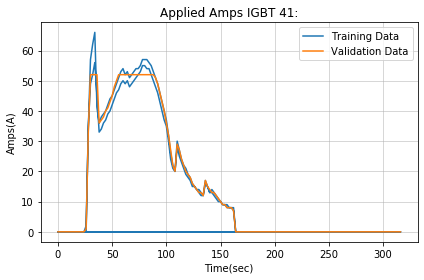

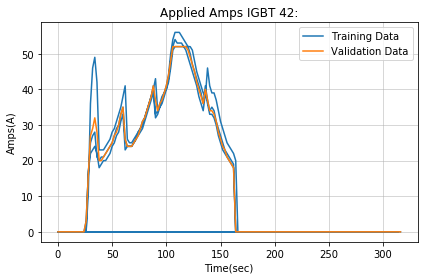

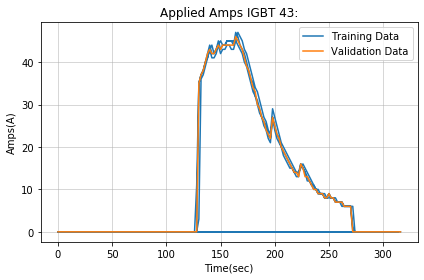

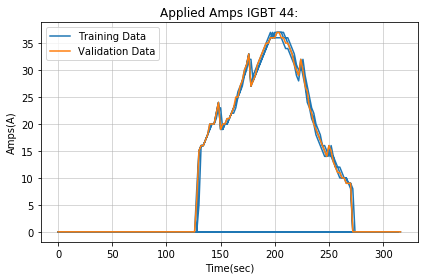

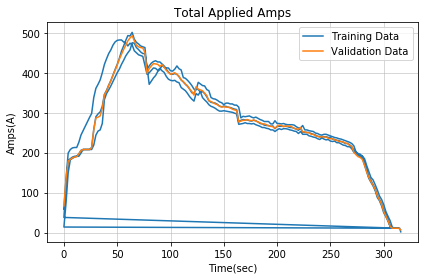

In [5]:
#convert features to a numpy array
xtrain=df_xtrain.values

#Reshape the array: no of samples x no of features
n_samples = len(df_xtrain.index)
n_features = len(df_xtrain.columns)
xtrain.reshape(n_samples,n_features)

#convert targets to a numpy array
ytrain=df_ytrain.values

#Rehsape array: samples x targets
n_targets = len(df_ytrain.columns)
ytrain.reshape(n_samples,n_targets)

#convert to a numpy array
xtest=df_xtest.values

#reshape array: Samples x Features
n_testsamples = len(df_xtest.index)
test_time = range(0,2*n_testsamples,2)
xtest.reshape(n_testsamples,n_features)

#convert targets to a numpy array
ytest=df_ytest.values

#Rehsape array: samples x targets
ytest.reshape(n_testsamples,n_targets)

print('Training Inputs (samples , features):',xtrain.shape)
print('Training Outputs (samples , Targets):',ytrain.shape)
print('Test Inputs (samples , features):',xtest.shape)
print('Test Outputs (samples , Targets):',ytest.shape)

#Visualise features
for i in range(n_features):
    plt.plot(train_time,xtrain[:,i],label='Training Data')
    plt.plot(test_time,xtest[:,i],label='Validation Data')
    plt.title('Applied Voltages IGBT %d:'%(i+9))
    plt.xlabel('Time(sec)')
    plt.ylabel('Volts(V)')
    plt.tight_layout()
    plt.grid(linestyle='-', linewidth=0.5)
    plt.legend()
    plt.show()

#Visualise targets
for i in range(n_targets):
    plt.plot(train_time,ytrain[:,i],label='Training Data')
    plt.plot(test_time,ytest[:,i],label='Validation Data')
    plt.title('Applied Amps IGBT %d:' %(i+9))
    plt.xlabel('Time(sec)')
    plt.ylabel('Amps(A)')
    plt.tight_layout()
    plt.grid(linestyle='-', linewidth=0.5)
    plt.legend()
    plt.show()
    
plt.plot(train_time,df_train['App_Amps'],label='Training Data')
plt.plot(test_time,df_test['App_Amps'],label='Validation Data')
plt.title('Total Applied Amps')
plt.xlabel('Time(sec)')
plt.ylabel('Amps(A)')
plt.tight_layout()
plt.grid(linestyle='-', linewidth=0.5)
plt.legend()
plt.show()

In [8]:
tr=pd.DataFrame(df_train.iloc[:316,:])
val=pd.DataFrame(df_train.iloc[316:,:])

df_xtr = tr.loc[:,'09V':'Coulombs']
df_ytr = tr.loc[:,'09A':'44A']

df_xval = val.loc[:,'09V':'Coulombs']
df_yval = val.loc[:,'09A':'44A']

#convert features to a numpy array
xtr=df_xtr.values

#Reshape the array: no of samples x no of features
n_samples = len(df_xtr.index)
n_features = len(df_xtr.columns)
xtr.reshape(n_samples,n_features)

#convert targets to a numpy array
ytr=df_ytr.values

#Rehsape array: samples x targets
n_targets = len(df_ytr.columns)
ytr.reshape(n_samples,n_targets)

#convert to a numpy array
xval=df_xval.values

#reshape array: Samples x Features
n_testsamples = len(df_xval.index)
test_time = range(0,2*n_testsamples,2)
xval.reshape(n_testsamples,n_features)

#convert targets to a numpy array
yval=df_yval.values

#Rehsape array: samples x targets
yval.reshape(n_testsamples,n_targets)

print(xval)

[[   22    22    22 ...     0     0    28]
 [  110   109   109 ...     0     0   178]
 [  194   194   194 ...     0     0   478]
 ...
 [    0     0     0 ...     0     0 89186]
 [    0     0     0 ...     0     0 89208]
 [    0     0     0 ...     0     0 89212]]


In [10]:
poly = PolynomialFeatures(2)
xtr_quad=poly.fit_transform(xtr)
xval_quad=poly.fit_transform(xval)
rr_linear = Ridge
rr_quad = Ridge

alphas = np.logspace(30, 36, 10000)
i=0

last_score_lr=1000000.0000
last_score_quad=1000000.0000

best_alpha_lr = 0
best_alpha_quad = 0


for alpha in alphas:
    ridge_model_lr = rr_linear(alpha).fit(xtr,ytr)
    ridge_model_quad = rr_quad(alpha).fit(xtr_quad,ytr)
    
    yval_lr=ridge_model_lr.predict(xval)
    yval_lr.reshape(n_testsamples,n_targets)
    
    yval_quad=ridge_model_quad.predict(xval_quad)
    yval_quad.reshape(n_testsamples,n_targets)
    
    yamps_lr=yval_lr.sum(axis=1)
    yamps_quad=yval_quad.sum(axis=1)
    
    Ridge_scores_lr = mean_absolute_error(xval[:,-1],yamps_lr)
    Ridge_scores_quad = mean_absolute_error(xval[:,-1],yamps_quad)
    
    if Ridge_scores_lr < last_score_lr:
        best_alpha_lr = alpha
    last_score_lr = Ridge_scores_lr
    
    if Ridge_scores_quad < last_score_quad:
        best_alpha_quad = alpha
    last_score_quad = Ridge_scores_quad
    
    i = i+1

print('Best Alpha Ridge Linear:',best_alpha_lr)
print('Best Alpha Ridge Quad:',best_alpha_quad)

Best Alpha Ridge Linear: 1e+30
Best Alpha Ridge Quad: 2.454929382500738e+34


In [21]:
linear_model=LinearRegression().fit(xtrain,ytrain) #linear model
ridgecv_model_lr=RidgeCV(alphas=np.logspace(9,11,10000),cv=5).fit(xtrain,ytrain) #Ridge Model with 10 fold Cross Validation

xtrain_quad=poly.fit_transform(xtrain)
xtest_quad=poly.fit_transform(xtest)

quad_model=LinearRegression().fit(xtrain_quad,ytrain) #linear model
ridgecv_model_quad=RidgeCV(alphas=np.logspace(9,11,10000),cv=5).fit(xtrain_quad,ytrain) #Ridge Model with 10 fold Cross Validation

#Linear Model prediction
y_pred_linear=linear_model.predict(xtest)

#Linear Ridge Model with optimized Alpha = 74026452687.26608
ridge_model_lr=Ridge(alpha=best_alpha_lr).fit(xtrain,ytrain)
y_pred_ridge_lr=ridge_model_lr.predict(xtest)

#Linear Ridge Model with 10 fold cross validation
y_pred_ridgecv_lr=ridgecv_model_lr.predict(xtest)

#Quadratic Model Predictions
y_pred_quad=quad_model.predict(xtest_quad)

#Quadratic Ridge Model with Optimized Alpha = 1353982843.3015454
ridge_model_quad=Ridge(alpha=best_alpha_quad).fit(xtrain_quad,ytrain)
y_pred_ridge_quad=ridge_model_quad.predict(xtest_quad)

#Quadration ridge model with Cross validation
y_pred_ridgecv_quad=ridgecv_model_quad.predict(xtest_quad)


In [22]:
#Linear Model Score:
y_pred_amps_linear=y_pred_linear.sum(axis=1)
linear_model_MAE=mean_absolute_error(df_test['App_Amps'],y_pred_amps_linear)
print('MAE Linear Model',linear_model_MAE)

#Linear Ridge model with Optimized Alpha
y_pred_amps_ridge_lr=y_pred_ridge_lr.sum(axis=1)
ridge_model_MAE_lr=mean_absolute_error(df_test['App_Amps'],y_pred_amps_ridge_lr)
print('MAE Linear Rridge Model',ridge_model_MAE_lr)

#Linear Ridge Model with CV
y_pred_amps_ridgecv_lr=y_pred_ridgecv_lr.sum(axis=1)
ridgecv_model_MAE_lr=mean_absolute_error(df_test['App_Amps'],y_pred_amps_ridgecv_lr)
print('MAE Linear Ridge CV Model',ridgecv_model_MAE_lr)

print(y_pred_ridgecv_lr.shape)
print(y_pred_quad.shape)

#Quadratic Model score
y_pred_amps_quad=y_pred_quad.sum(axis=1)
quad_model_MAE=mean_absolute_error(df_test['App_Amps'],y_pred_amps_quad)
print('MAE Quadratic Model',quad_model_MAE)

#Quadratic ridge model with optimized alpha
y_pred_amps_ridge_quad=y_pred_ridge_quad.sum(axis=1)
ridge_model_MAE_quad=mean_absolute_error(df_test['App_Amps'],y_pred_amps_ridge_quad)
print('MAE Quadratic Rridge Model',ridge_model_MAE_quad)

#Quadratic Risge Model with CV
y_pred_amps_ridgecv_quad=y_pred_ridgecv_quad.sum(axis=1)
ridgecv_model_MAE=mean_absolute_error(df_test['App_Amps'],y_pred_amps_ridgecv_quad)
print('MAE Quadratic Ridge CV Model',ridgecv_model_MAE)


MAE = [linear_model_MAE,ridge_model_MAE_lr,ridgecv_model_MAE_lr,
      quad_model_MAE,ridge_model_MAE_quad,ridgecv_model_MAE]

MAE Linear Model 23.527585096525215
MAE Linear Rridge Model 86.50453200147983
MAE Linear Ridge CV Model 68.07621910061737
(159, 36)
(159, 36)
MAE Quadratic Model 7016.374024058008
MAE Quadratic Rridge Model 86.5045320014725
MAE Quadratic Ridge CV Model 10.522004825091724


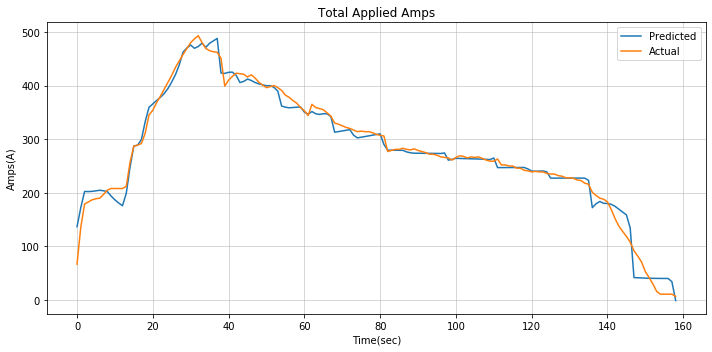

Absolute Error on Coulombs 26507.717712474987 A.sec
Percentage Error on Coulombs 0.32731849006717073 %


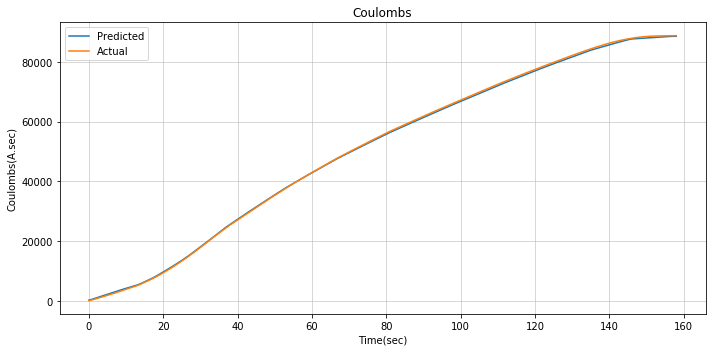

In [26]:
plt.rcParams["figure.figsize"] = (10,5)
df_predict = pd.DataFrame(data=y_pred_ridgecv_quad,columns=df_ytest.columns,index=df_ytest.index)
df_predict['App_Amps']=df_predict.sum(axis=1)
df_predict['Coulombs']=df_predict['App_Amps'].mul(2).cumsum()
df_predict.head()

plt.plot(df_ytest.index,df_predict['App_Amps'],label='Predicted')
plt.plot(df_ytest.index,df_test['App_Amps'],label='Actual')
plt.title('Total Applied Amps')
plt.xlabel('Time(sec)')
plt.ylabel('Amps(A)')
plt.legend()
plt.tight_layout()
plt.grid(linestyle='-', linewidth=0.5)
plt.show()

Coulombs_error = df_test['Coulombs'].sum()-df_predict['Coulombs'].sum()
perc_error = (Coulombs_error/df_test['Coulombs'].sum())*100

print('Absolute Error on Coulombs',Coulombs_error,'A.sec')
print('Percentage Error on Coulombs',perc_error,'%')

plt.plot(df_ytest.index,df_predict['Coulombs'],label='Predicted')
plt.plot(df_ytest.index,df_test['Coulombs'],label='Actual')
plt.title('Coulombs')
plt.xlabel('Time(sec)')
plt.ylabel('Coulombs(A.sec)')
plt.legend()
plt.tight_layout()
plt.grid(linestyle='-', linewidth=0.5)
plt.show()


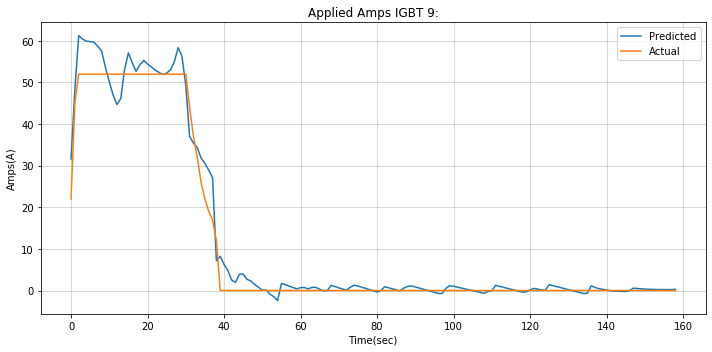

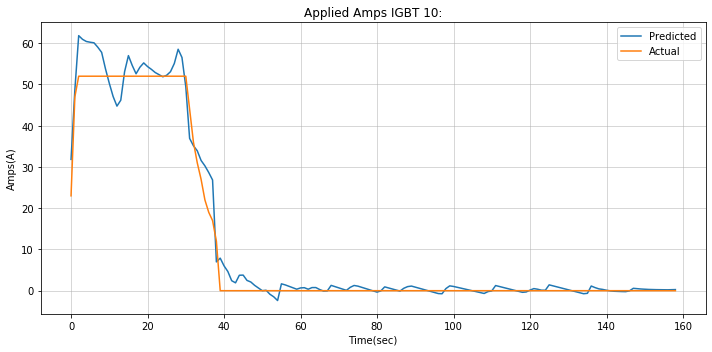

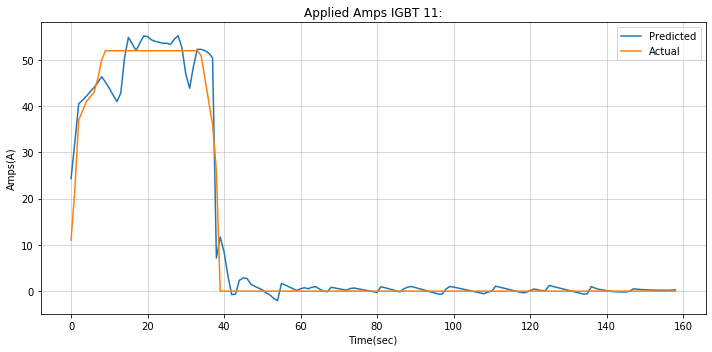

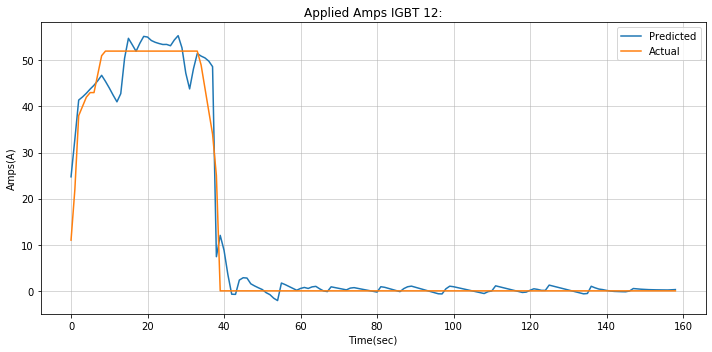

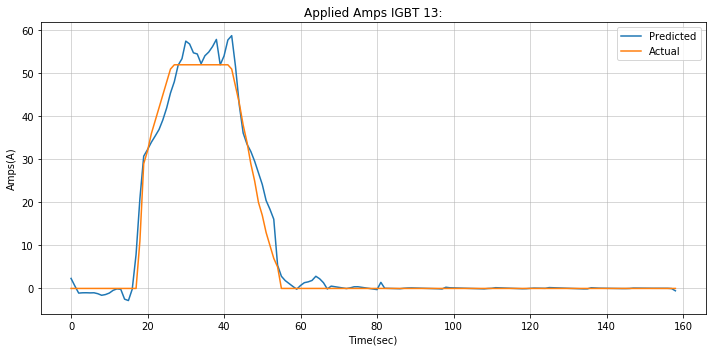

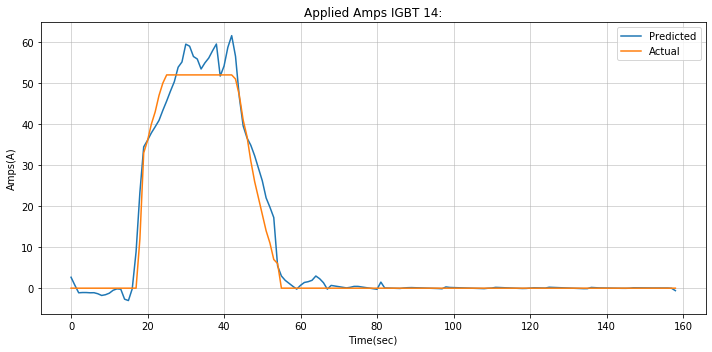

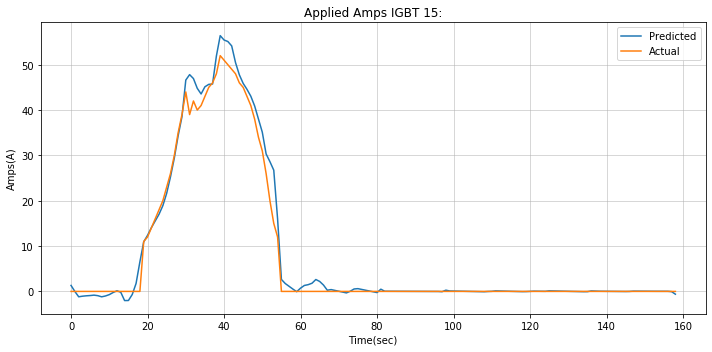

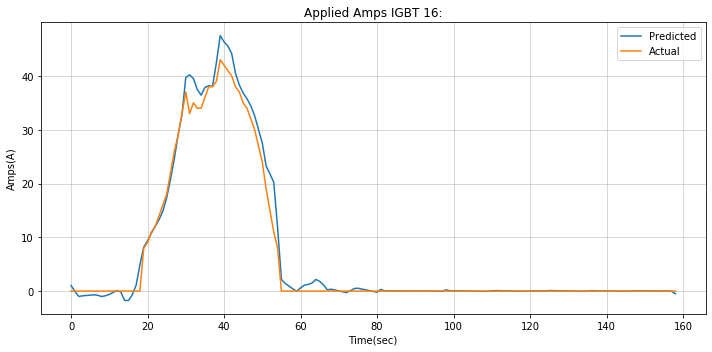

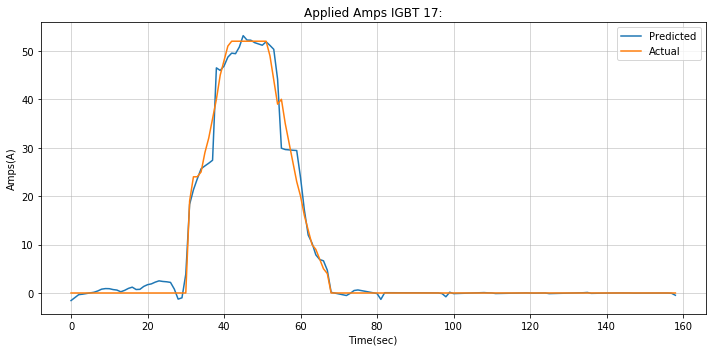

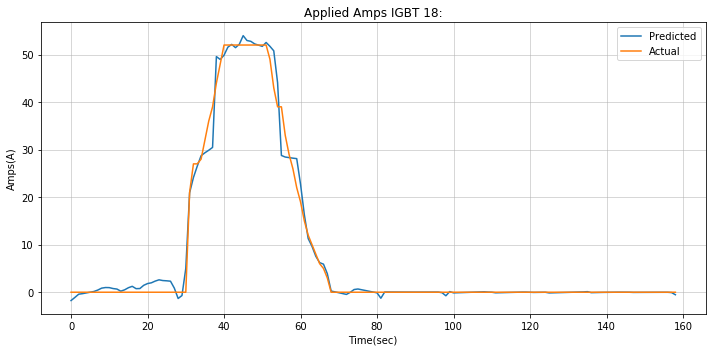

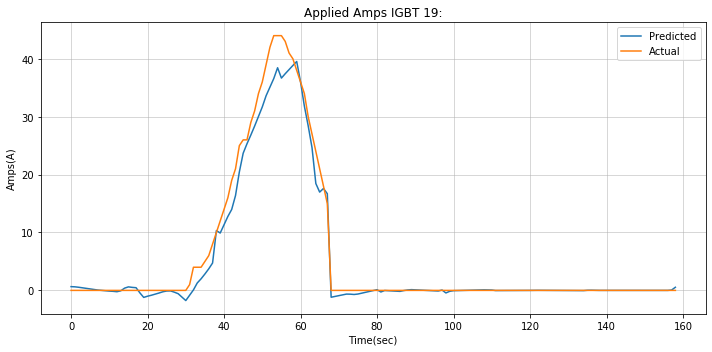

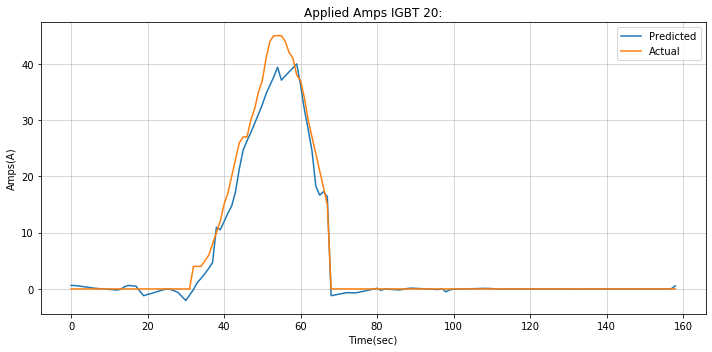

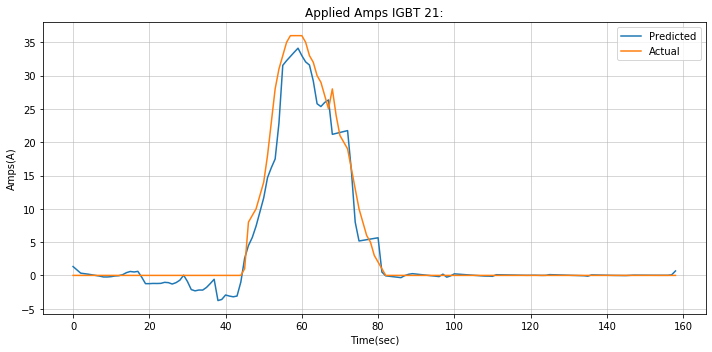

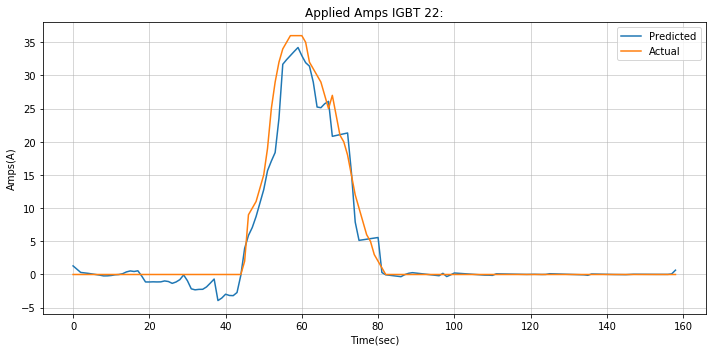

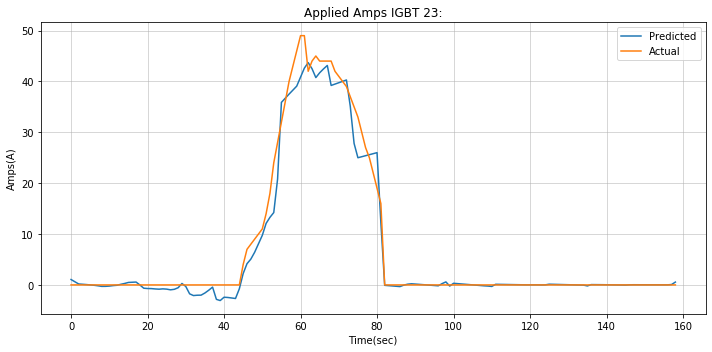

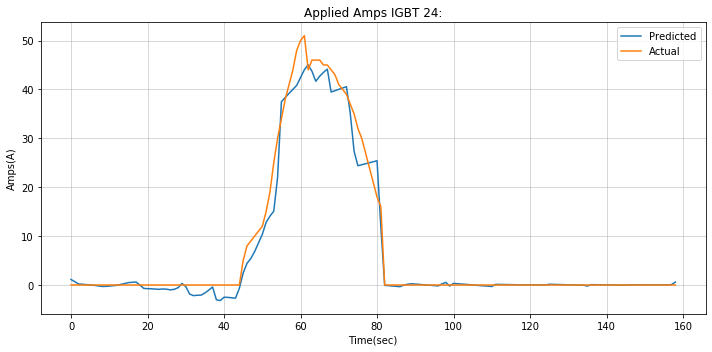

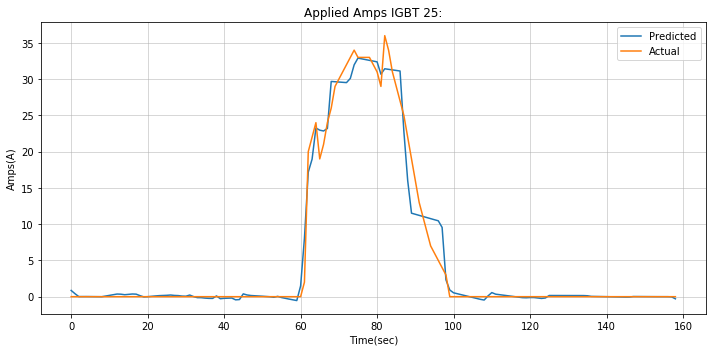

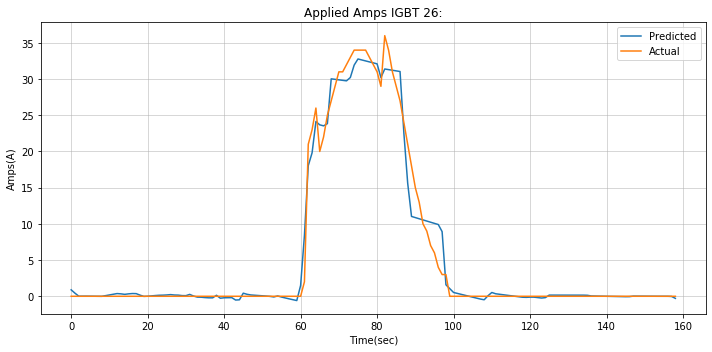

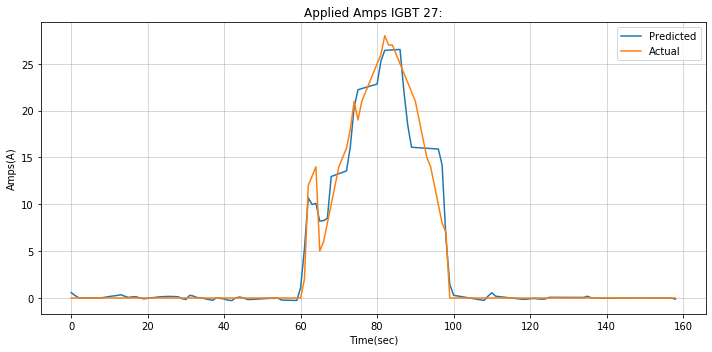

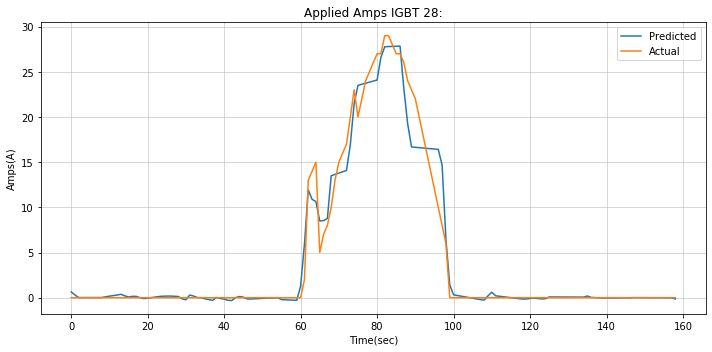

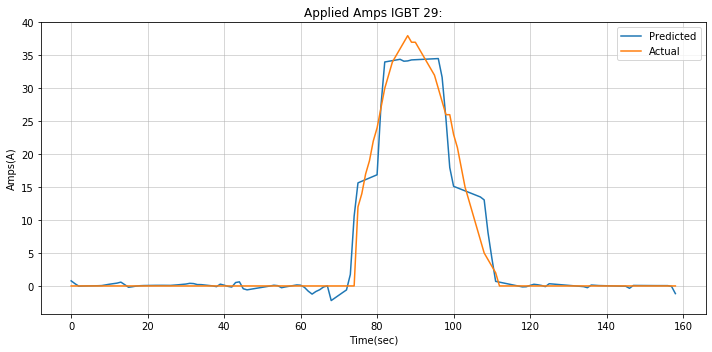

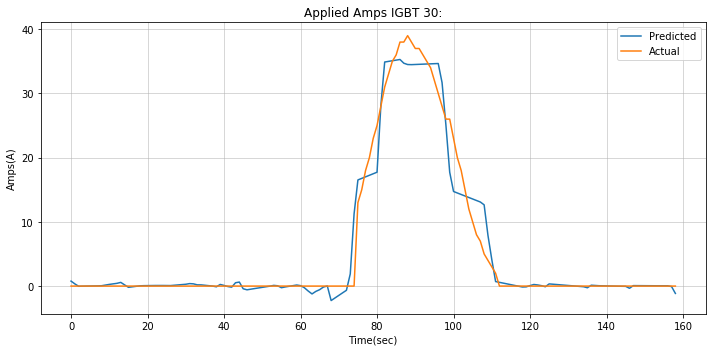

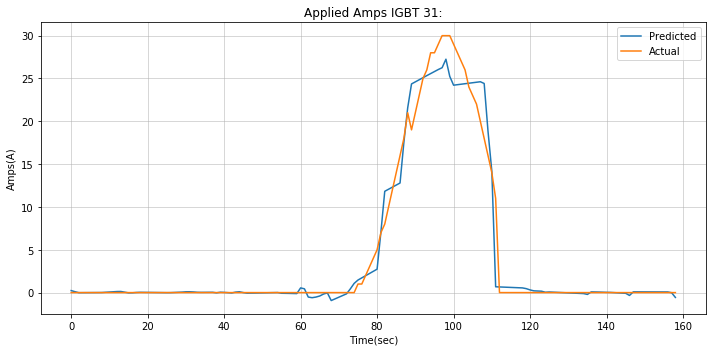

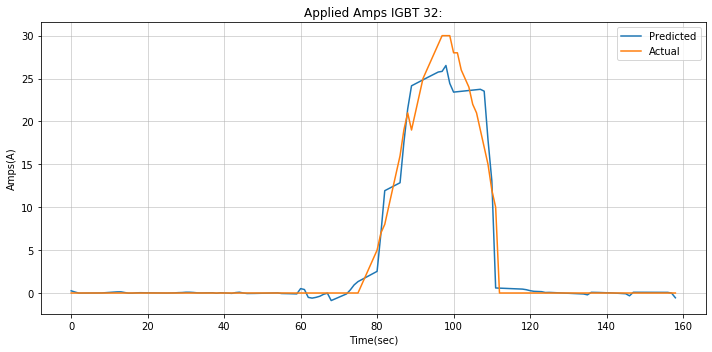

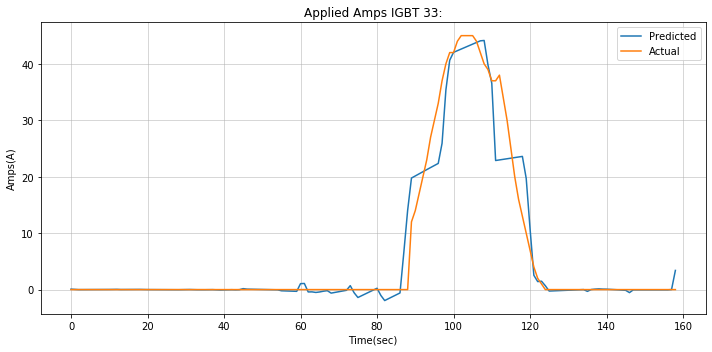

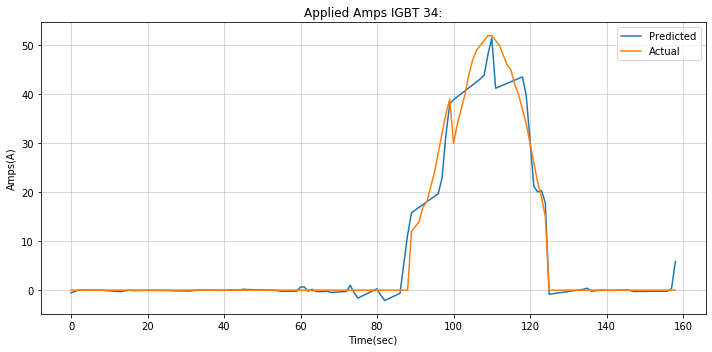

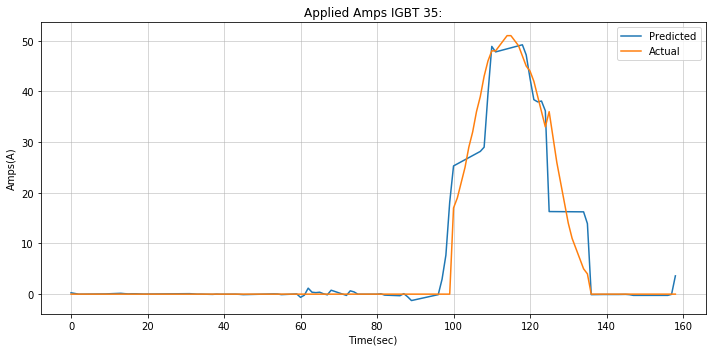

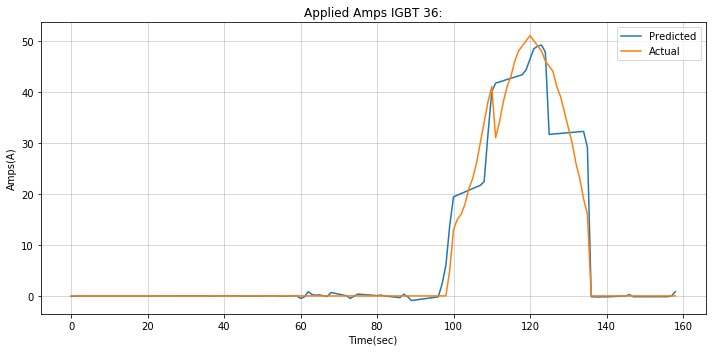

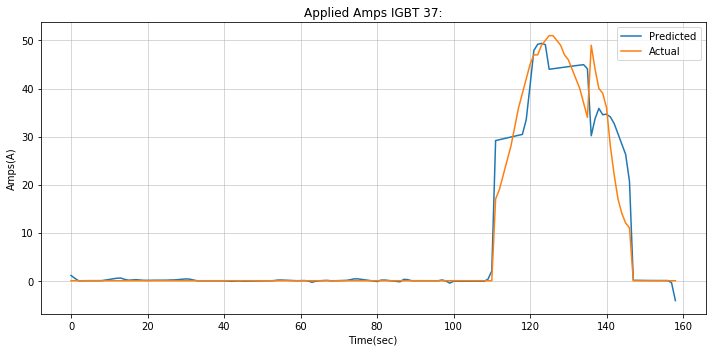

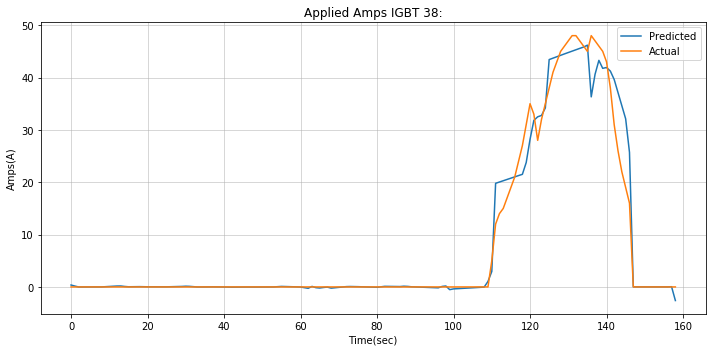

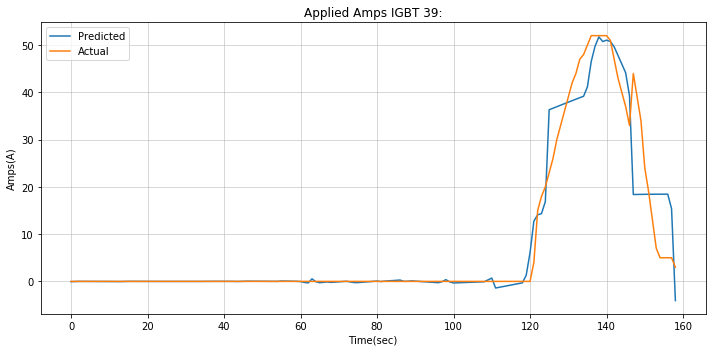

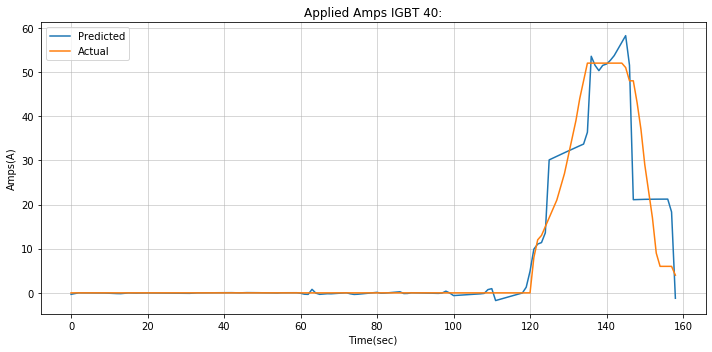

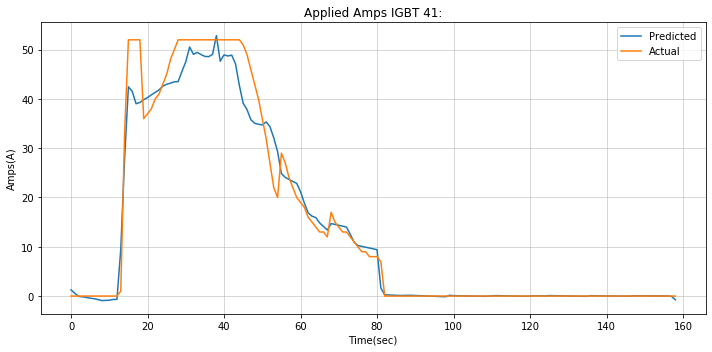

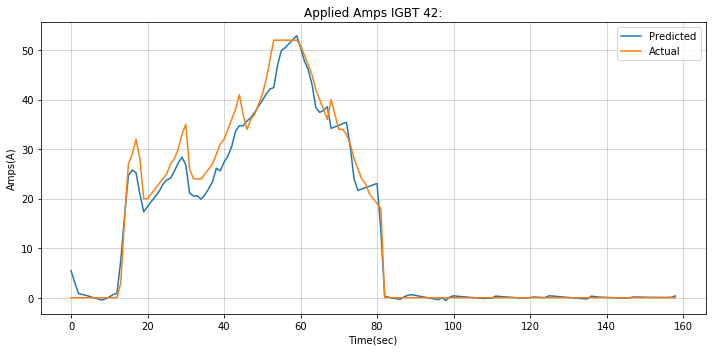

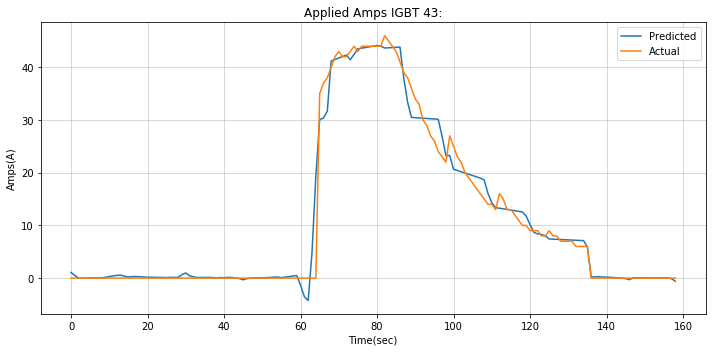

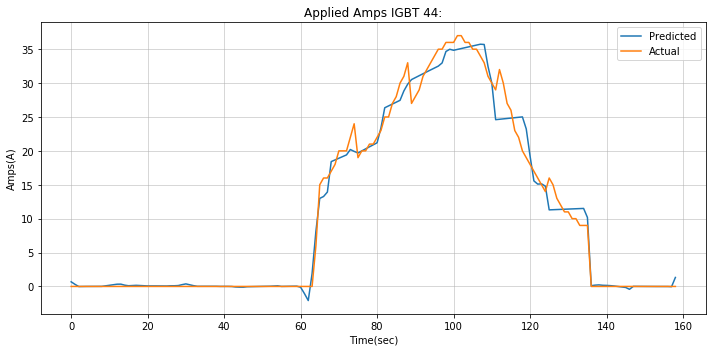

In [28]:
#Visualise targets
for i in range(n_targets):
    plt.plot(df_ytest.index,df_predict.iloc[:,i],label='Predicted')
    plt.plot(df_ytest.index,df_ytest.iloc[:,i],label='Actual')
    errors = mean_absolute_error(df_ytest.iloc[:,i],df_predict.iloc[:,i])
    plt.title('Applied Amps IGBT %d:' %(i+9))
    plt.xlabel('Time(sec)')
    plt.ylabel('Amps(A)')
    plt.tight_layout()
    plt.grid(linestyle='-', linewidth=0.5)
    plt.legend()
    plt.show()


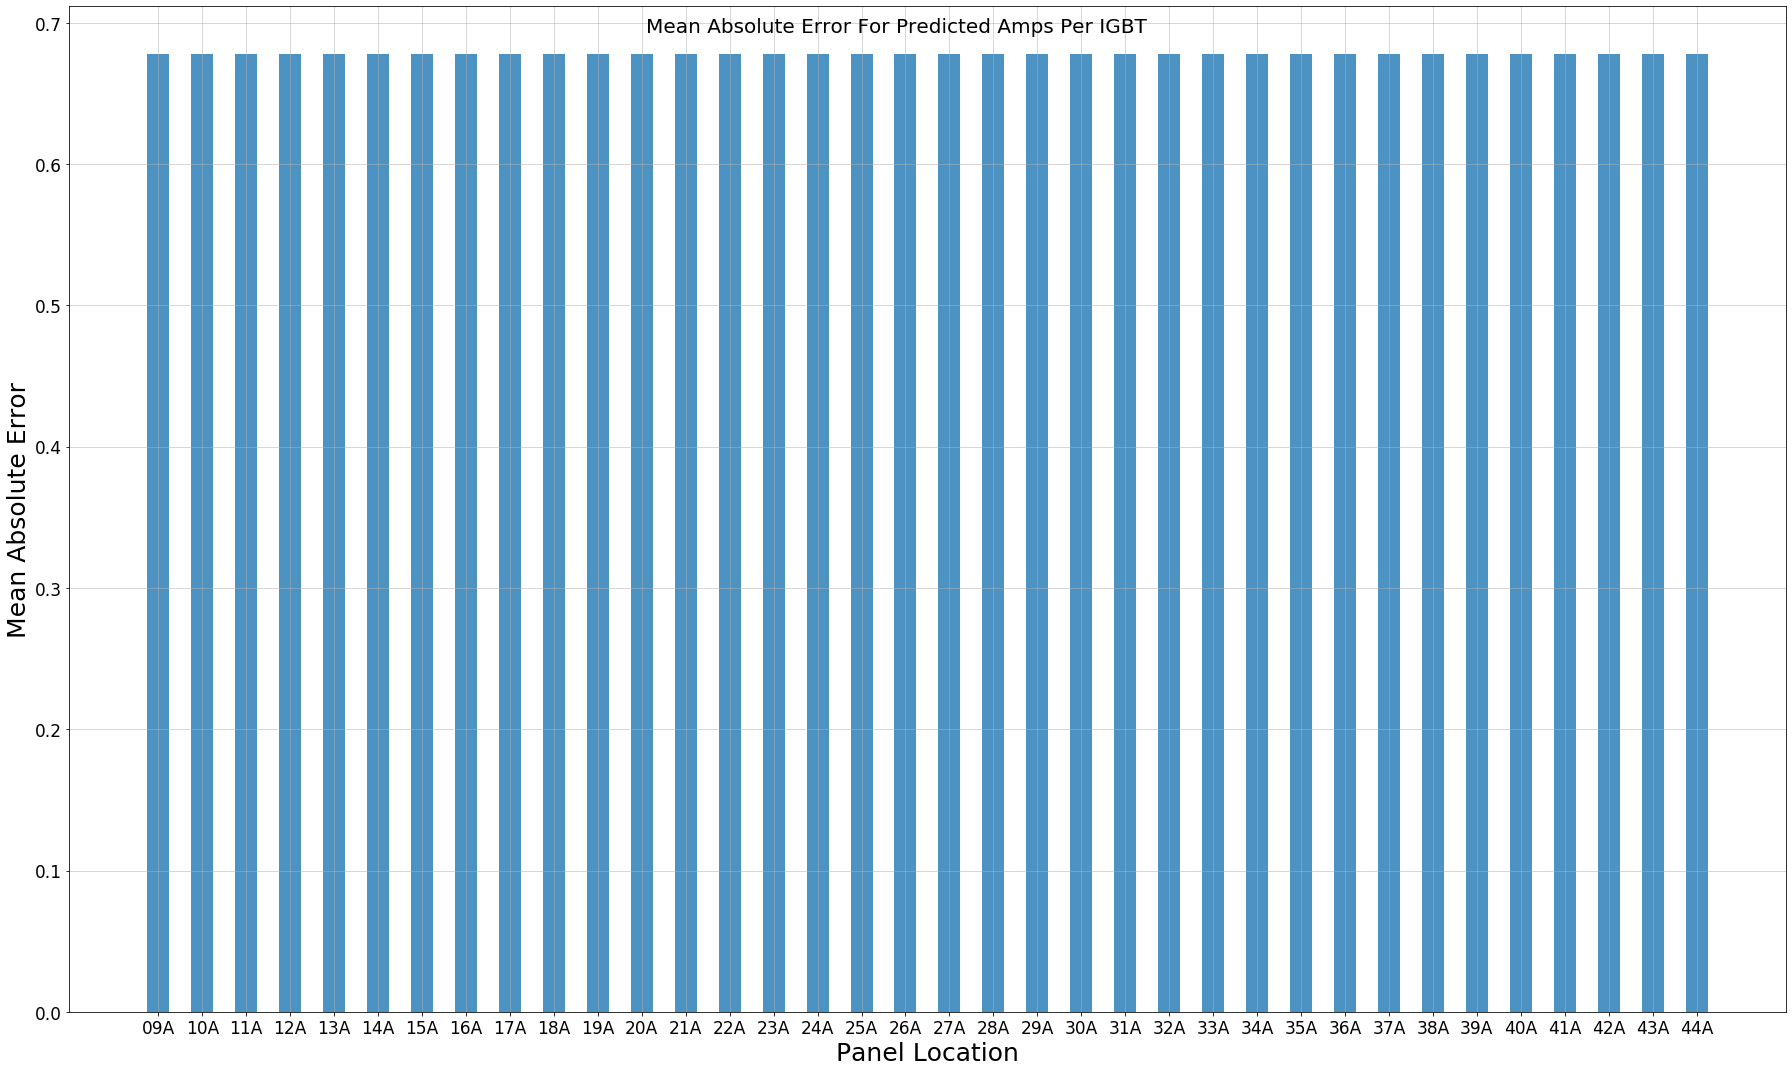

In [59]:
plt.rcParams["figure.figsize"] = (25,15) 

n_groups= df_ytest.columns.size
bar_width = 0.5
opacity=0.8
index = np.arange(n_groups)

plt.bar(index,errors,bar_width,alpha=opacity)
plt.suptitle('Mean Absolute Error For Predicted Amps Per IGBT',fontsize=20)
plt.xlabel('Panel Location',fontsize=25)
plt.ylabel('Mean Absolute Error',fontsize=25)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.xticks(index, df_ytest.columns)
plt.grid(linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

In [62]:
#Write Data to CSV
df_predict.to_csv('Predicted_Model2C.csv')

#Save Model to disk (Quadratic Ridge Model with Optimised Alpha)
fileName='ECModel_2C_AppAmps.joblib'
dump(ridge_model_quad, fileName) 


['ECModel_2C_AppAmps.joblib']